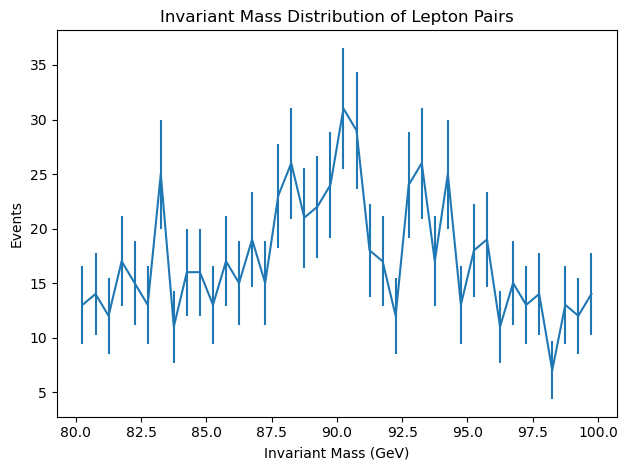

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# load data
data = pd.read_csv('atlas_z_to_ll.csv')

# calculating mass of particle which decayed to produce each lapton pair
px1 = data['pt1'] * np.cos(data['pt1'])
py1 = data['pt1'] * np.sin(data['pt1'])
pz1 = data['pt1'] * np.sinh(data['eta1'])
E1 = data['E1']
px2 = data['pt2'] * np.cos(data['pt2'])
py2 = data['pt2'] * np.sin(data['pt2'])
pz2 = data['pt2'] * np.sinh(data['eta2'])
E2 = data['E2']

px = px1 + px2
py = py1 + py2
pz = py1 + py2
E = E1 + E2

M = np.sqrt(np.abs((E**2 - (px**2 + py**2 + pz**2))))

# plot histogram
bins = np.linspace(80, 100, 41)

fig, ax = plt.subplots()

counts, edges = np.histogram(M, bins=bins)
centers = (edges[:-1] + edges[1:]) / 2
errors = np.sqrt(counts)

ax.errorbar(centers, counts, yerr=errors)
ax.set_xlabel('Invariant Mass (GeV)')
ax.set_ylabel('Events')
ax.set_title('Invariant Mass Distribution of Lepton Pairs')
plt.tight_layout()

Text(0, -0.75, '$m_0$ = 74.9 ± 13.7 GeV  $\\Gamma$ = 63.4 ± 33.5 GeV  $\\chi^2$NDOF = 17.0/10 = 1.70  $p$-value = 0.074')

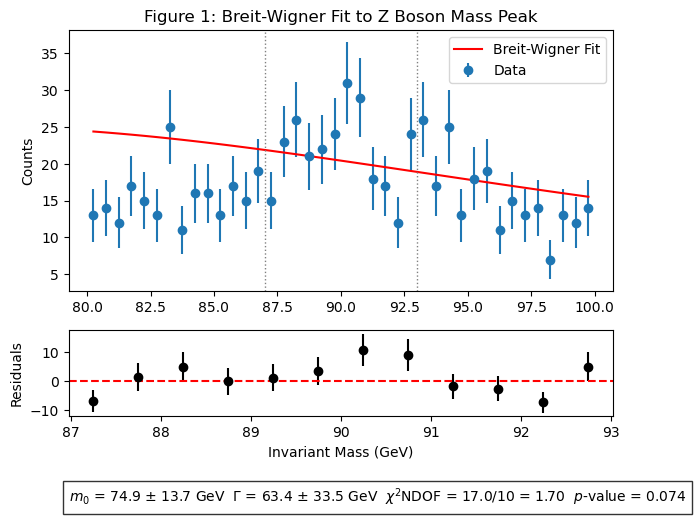

In [2]:
from scipy.optimize import curve_fit
from scipy.stats import chi2 as chi2_dist

# decay distribution function
def breit_wigner(m, m0, gamma):
    return (gamma / 2) / (np.pi * ((m - m0)**2 + (gamma / 2)**2))

# fit mass distribution
mask = (centers > 87) & (centers < 93)
x_fit = centers[mask]
y_fit = counts[mask]
yerr_fit = errors[mask]

def scaled_breit_wigner(m, m0, gamma):
    return 2500 * breit_wigner(m, m0, gamma)

popt, pcov = curve_fit(
    scaled_breit_wigner,
    x_fit,
    y_fit,
    sigma=yerr_fit,
    p0=[91.2, 2.5],
    absolute_sigma=True
)

m0_fit, gamma_fit = popt
m0_err, gamma_err = np.sqrt(np.diag(pcov))

# plot data
fig, (ax_main, ax_resid) = plt.subplots(2, 1, gridspec_kw={"height_ratios": [3, 1]})
ax_main.errorbar(centers, counts, yerr=errors, fmt='o', label='Data')
ax_main.plot(centers, scaled_breit_wigner(centers, *popt), 
             color='red', label='Breit-Wigner Fit')
ax_main.axvline(87, color='gray', linestyle=':', linewidth=1)
ax_main.axvline(93, color='gray', linestyle=':', linewidth=1)
ax_main.set_ylabel('Counts')
ax_main.legend()
ax_main.set_title("Figure 1: Breit-Wigner Fit to Z Boson Mass Peak")

residuals = y_fit - scaled_breit_wigner(x_fit, *popt)
ax_resid.errorbar(x_fit, residuals, yerr=yerr_fit, fmt='o', color='black')
ax_resid.axhline(0, color='red', linestyle='--')
ax_resid.set_xlabel('Invariant Mass (GeV)')
ax_resid.set_ylabel('Residuals')
fig.tight_layout()

# chi-square, reduced-chi-square, and p-value
chi2 = np.sum(((y_fit - scaled_breit_wigner(x_fit, *popt)) / yerr_fit)**2)
ndof = len(y_fit) - len(popt)  # number of degrees of freedom
chi2_red = chi2 / ndof
p_value = 1 - chi2_dist.cdf(chi2, ndof)

# calculate best fit mass and annotate
text = (
    fr"$m_0$ = {m0_fit:.1f} ± {m0_err:.1f} GeV  "
    fr"$\Gamma$ = {gamma_fit:.1f} ± {gamma_err:.1f} GeV  "
    fr"$\chi^2$NDOF = {chi2:.1f}/{ndof} = {chi2_red:.2f}  "
    fr"$p$-value = {p_value:.3f}"
)
ax_main.text(0, -0.75, text, transform=ax_main.transAxes,
             fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))

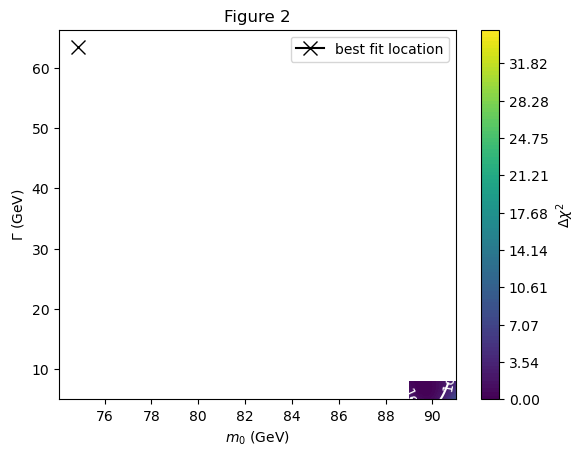

In [3]:
# scaled breit-wigner function
def scaled_breit_wigner(m, m0, gamma):
    return (gamma / 2)**2 / ((m - m0)**2 + (gamma / 2)**2)

# 2D chi-square scan
m_vals = np.linspace(89, 91, 300)
gamma_vals = np.linspace(5, 8, 300)
M, G = np.meshgrid(m_vals, gamma_vals)

chi2_grid = np.zeros_like(M)

for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        model = scaled_breit_wigner(x_fit, M[i, j], G[i, j])
        model *= np.sum(y_fit) / (2 * np.sum(model))
        chi2_grid[i, j] = np.sum(((y_fit - model) / yerr_fit)**2)

chi2_min = np.min(chi2_grid)
delta_chi2 = chi2_grid - chi2_min

# filled contour plot
fig2, ax2 = plt.subplots()
levels = np.linspace(0, 35, 100)
contour = ax2.contourf(M, G, np.clip(delta_chi2, 0, 35), levels=levels, cmap='viridis')
cbar = plt.colorbar(contour, ax=ax2)
cbar.set_label(r'$\Delta \chi^2$')

# confidence levels
sigma_levels = [2.30, 11.83]
lines = ax2.contour(M, G, delta_chi2, levels=sigma_levels, colors=['white', 'red'],
                    linestyles=['solid', 'dashed'])
ax2.clabel(lines, fmt={2.30: '1σ', 11.83: '3σ'})

ax2.plot(m0_fit, gamma_fit, marker='x', color='black', markersize=10, label='best fit location')
ax2.set_xlabel(r'$m_0$ (GeV)')
ax2.set_ylabel(r'$\Gamma$ (GeV)')
ax2.set_title("Figure 2")
ax2.legend()
fig.tight_layout()